In [1]:
# import torch
# from sam2.build_sam import build_sam2 # for images
# from sam2.build_sam import build_sam2_video_predictor # for videos

# from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator
# from sam2.sam2_image_predictor import SAM2ImagePredictor

# import numpy as np
# import os
# import matplotlib.pyplot as plt
# import cv2

In [2]:
# if torch.cuda.is_available():
#     device = torch.device("cuda")
# else:
#     device = torch.device("cpu")

# device

# Image Segmentation

In [3]:
# np.random.seed(3)

# def show_mask(mask, ax, random_color=False, borders = True):
#     if random_color:
#         color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
#     else:
#         color = np.array([30/255, 144/255, 255/255, 0.6])
#     h, w = mask.shape[-2:]
#     mask = mask.astype(np.uint8)
#     mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
#     if borders:
#         import cv2
#         contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
#         # Try to smooth contours
#         contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
#         mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2) 
#     ax.imshow(mask_image)

# def show_points(coords, labels, ax, marker_size=375):
#     pos_points = coords[labels==1]
#     neg_points = coords[labels==0]
#     ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
#     ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

# def show_box(box, ax):
#     x0, y0 = box[0], box[1]
#     w, h = box[2] - box[0], box[3] - box[1]
#     ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))    

# def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
#     for i, (mask, score) in enumerate(zip(masks, scores)):
#         plt.figure(figsize=(10, 10))
#         plt.imshow(image)
#         show_mask(mask, plt.gca(), borders=borders)
#         if point_coords is not None:
#             assert input_labels is not None
#             show_points(point_coords, input_labels, plt.gca())
#         if box_coords is not None:
#             # boxes
#             show_box(box_coords, plt.gca())
#         if len(scores) > 1:
#             plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
#         plt.axis('off')
#         plt.show()

In [4]:
# image = cv2.imread("/home/niru/Downloads/Cat03.jpg")
# # cv2.imshow("frame", image)
# cv2.waitKey(0)
# # cv2.destroyAllWindows()
# image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

# plt.figure(figsize=(3,3))
# plt.imshow(image)
# plt.show()


In [5]:
# checkpoint = "segment-anything-2/checkpoints/sam2_hiera_large.pt"
# model_cfg = "sam2_hiera_l.yaml"
# predictor = SAM2AutomaticMaskGenerator(build_sam2(model_cfg, checkpoint, device=device, apply_postprocessing=False))

# masks = predictor.generate(image)


In [6]:
# import supervision as sv

# mask_annotator = sv.MaskAnnotator()
# detections = sv.Detections.from_sam(masks)
# detections.class_id = [i for i in range(len(detections))]
# annotated_image = mask_annotator.annotate(image, detections)

# sv.plot_image(image=annotated_image, size=(4, 4))

# Video Segmentation

In [7]:
# checkpoint = "segment-anything-2/checkpoints/sam2_hiera_small.pt"
# config = "sam2_hiera_s.yaml"
# model = build_sam2_video_predictor(config, checkpoint, device=device)

In [8]:
# import supervision as sv

# frames_generator = sv.get_video_frames_generator("input_video.mp4")
# sink = sv.ImageSink(
#     target_dir_path="video-frames",
#     image_name_pattern="{:05d}.jpeg")

# with sink:
#     for frame in frames_generator:
#         sink.save_image(frame)

In [9]:
# inference_state = model.init_state("video-frames")
# model.reset_state(inference_state)

In [10]:
# # Selecting points in first frame (will be automated later)

# def click_event(event, x, y, flags, param):
#     if event == cv2.EVENT_LBUTTONDOWN:
#         cv2.circle(img, (x, y), 3, (0, 0, 255), -1)
#         points.append(np.array([x, y]))
#         cv2.imshow('image', img)

# points = []
# img = cv2.imread('/home/niru/codes/disassembly/SAM2/video-frames/00000.jpeg') # Replace 'your_image.jpg' with your image path
# cv2.imshow('image', img)
# cv2.setMouseCallback('image', click_event)

# cv2.waitKey(0)
# cv2.destroyAllWindows()
# points = np.array(points)
# print("Selected Points:", points)


In [11]:
# prompts = {}

# labels = np.array([1])
# frame_idx = 0
# tracker_id_1 = 1

# prompts[tracker_id_1] = points[0], labels

# _, object_ids, mask_logits = model.add_new_points_or_box(
#     inference_state=inference_state,
#     frame_idx=frame_idx,
#     obj_id=tracker_id_1,
#     points=[points[0]],
#     labels=labels,
# )

# tracker_id_2 = 2
# prompts[tracker_id_2] = points[1], labels

# _, object_ids, mask_logits = model.add_new_points_or_box(
#     inference_state=inference_state,
#     frame_idx=frame_idx,
#     obj_id=tracker_id_2,
#     points=[points[1]],
#     labels=labels,
# )


In [12]:
# colors = ['#FF1493', '#00BFFF', '#FF6347', '#FFD700']
# mask_annotator = sv.MaskAnnotator(
#     color=sv.ColorPalette.from_hex(colors),
#     color_lookup=sv.ColorLookup.TRACK)

# video_info = sv.VideoInfo.from_video_path("/home/niru/Downloads/IMG_0066-ezgif.com-video-to-mp4-converter.mp4")
# frames_paths = sorted(sv.list_files_with_extensions(
#     directory="/home/niru/codes/disassembly/SAM2/video-frames", 
#     extensions=["jpeg"]))


# with sv.VideoSink("final_output.mp4", video_info=video_info) as sink:
#     for frame_idx, object_ids, mask_logits in model.propagate_in_video(inference_state):
#         frame = cv2.imread(frames_paths[frame_idx])
#         masks = (mask_logits > 0.0).cpu().numpy()
#         N, X, H, W = masks.shape
#         masks = masks.reshape(N * X, H, W)
#         detections = sv.Detections(
#             xyxy=sv.mask_to_xyxy(masks=masks),
#             mask=masks,
#             tracker_id=np.array(object_ids)
#         )
#         frame = mask_annotator.annotate(frame, detections)
#         sink.write_frame(frame)

# Video Segmentation 2 (direct mask input)

In [13]:
from sam2.build_sam import build_sam2
from sam2.build_sam import build_sam2_video_predictor
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2



if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")



In [14]:
! ffmpeg -i "/home/niru/codes/disassembly/SAM2/input_video.mp4" -q:v 2 -start_number 0 video-frames/'%05d.jpeg'

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [15]:
# get automatic masks for the first frame first
first_frame_path = "/home/niru/codes/disassembly/SAM2/video-frames/00000.jpeg"
first_frame = cv2.imread(first_frame_path)
checkpoint = "segment-anything-2/checkpoints/sam2_hiera_tiny.pt"
model_cfg = "sam2_hiera_t.yaml"
predictor = SAM2AutomaticMaskGenerator(build_sam2(model_cfg, checkpoint, device=device, apply_postprocessing=False), points_per_side=8)

masks = predictor.generate(first_frame)





/home/niru/codes/disassembly/SAM2/segment-anything-2/sam2/modeling/sam/transformer.py:270: UserWarning: Memory efficient kernel not used because: (Triggered internally at ../aten/src/ATen/native/transformers/cuda/sdp_utils.cpp:723.)
  out = F.scaled_dot_product_attention(q, k, v, dropout_p=dropout_p)
/home/niru/codes/disassembly/SAM2/segment-anything-2/sam2/modeling/sam/transformer.py:270: UserWarning: Memory Efficient attention has been runtime disabled. (Triggered internally at ../aten/src/ATen/native/transformers/sdp_utils_cpp.h:495.)
  out = F.scaled_dot_product_attention(q, k, v, dropout_p=dropout_p)
/home/niru/codes/disassembly/SAM2/segment-anything-2/sam2/modeling/sam/transformer.py:270: UserWarning: Flash attention kernel not used because: (Triggered internally at ../aten/src/ATen/native/transformers/cuda/sdp_utils.cpp:725.)
  out = F.scaled_dot_product_attention(q, k, v, dropout_p=dropout_p)
/home/niru/codes/disassembly/SAM2/segment-anything-2/sam2/modeling/sam/transformer.py:

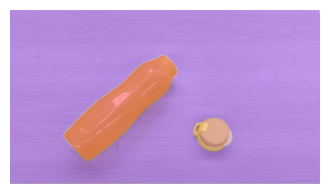

In [16]:
import supervision as sv

mask_annotator = sv.MaskAnnotator()
detections = sv.Detections.from_sam(masks)
detections.class_id = [i for i in range(len(detections))]
annotated_image = mask_annotator.annotate(first_frame, detections)

sv.plot_image(image=annotated_image, size=(4, 4))

In [17]:
masks[0]["segmentation"]

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [18]:
sam2_checkpoint = "/home/niru/codes/disassembly/SAM2/segment-anything-2/checkpoints/sam2_hiera_tiny.pt"
model_cfg = "sam2_hiera_t.yaml"
predictor2 = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)

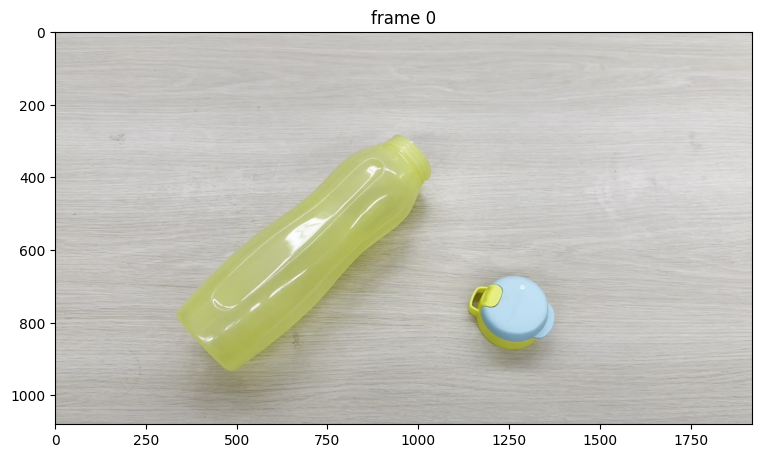

In [19]:
# `video_dir` a directory of JPEG frames with filenames like `<frame_index>.jpg`
video_dir = "video-frames"

# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

# take a look the first video frame
frame_idx = 0
plt.figure(figsize=(9, 6))
plt.title(f"frame {frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[frame_idx])))

In [20]:
inference_state = predictor2.init_state(video_path=video_dir)
predictor2.reset_state(inference_state)

frame loading (JPEG): 100%|██████████| 427/427 [00:16<00:00, 25.50it/s]


In [21]:
def add_points_to_segmentor(mask, mask_id):
    _, _, _ = predictor2.add_new_mask(inference_state=inference_state, frame_idx=0, obj_id=mask_id,mask=mask)

In [22]:
for i in range(len(masks)):
    add_points_to_segmentor(masks[i]['segmentation'], i)


Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/segment-anything-2/blob/main/INSTALL.md).


In [23]:
torch.cuda.empty_cache() 

In [24]:
colors = ['#FF1493', '#00BFFF', '#FF6347', '#FFD700']
mask_annotator = sv.MaskAnnotator(
    color=sv.ColorPalette.from_hex(colors),
    color_lookup=sv.ColorLookup.TRACK)

video_info = sv.VideoInfo.from_video_path("/home/niru/codes/disassembly/SAM2/input_video.mp4")
frames_paths = sorted(sv.list_files_with_extensions(
    directory="video-frames", 
    extensions=["jpeg"]))

with sv.VideoSink("/home/niru/codes/disassembly/SAM2/final_output.mp4", video_info=video_info) as sink:
    for frame_idx, object_ids, mask_logits in predictor2.propagate_in_video(inference_state):
        frame = cv2.imread(frames_paths[frame_idx])
        masks = (mask_logits > 0.0).cpu().numpy()
        N, X, H, W = masks.shape
        masks = masks.reshape(N * X, H, W)
        detections = sv.Detections(
            xyxy=sv.mask_to_xyxy(masks=masks),
            mask=masks,
            tracker_id=np.array(object_ids)
        )
        frame = mask_annotator.annotate(frame, detections)
        sink.write_frame(frame)

propagate in video:  81%|████████  | 345/427 [05:27<01:17,  1.05it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 112.00 MiB. GPU 0 has a total capacity of 7.78 GiB of which 77.88 MiB is free. Including non-PyTorch memory, this process has 7.65 GiB memory in use. Of the allocated memory 7.14 GiB is allocated by PyTorch, and 345.22 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)